##Question 1##
Convolutional Autoencoder for Fashion data

##I used pytorch for quesiton1 and 2 , for question3, i used keras##

In [1]:
# import standard PyTorch modules
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter # TensorBoard support

# import torchvision module to handle image manipulation
import torchvision
import torchvision.transforms as transforms

# calculate train time, writing train data to files etc.
import time
import pandas as pd
import json
from IPython.display import clear_output
import random
import matplotlib.pyplot as plt
import torch
from   torch.autograd import Variable

import numpy as np
import torchvision
from   torchvision import datasets, transforms
torch.set_printoptions(linewidth=120)
torch.set_grad_enabled(True)  

In [3]:

# Use standard FashionMNIST dataset
train_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

0it [00:00, ?it/s]

26427392it [00:04, 5786116.39it/s]                              


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


0it [00:00, ?it/s]

32768it [00:00, 41160.69it/s]                           
0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


4423680it [00:02, 1661226.05it/s]                             
0it [00:00, ?it/s]

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw


8192it [00:00, 14167.43it/s]            

Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw
Processing...
Done!


In [0]:

# Use standard FashionMNIST dataset test
test_set = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.Compose([
        transforms.ToTensor()                                 
    ])
)

In [0]:

IMAGE_SIZE = 784
IMAGE_WIDTH = IMAGE_HEIGHT = 28

# Hyperparameters
code_size = 20
num_epochs = 50
batch_size = 128
lr = 0.002
optimizer_cls = optim.Adam

In [0]:
##load train and test
train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=batch_size, num_workers=4, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, batch_size=batch_size, num_workers=4)

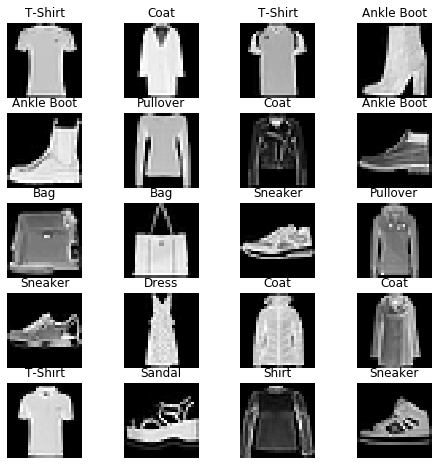

In [13]:
##show the data
classes = ('T-Shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot')
def imshow(img):
  npimg = img.numpy() #convert the tensor to numpy for displaying the image
  plt.imshow(np.transpose(npimg, (1, 2, 0))) 
  plt.show()
labels=['Shirt','Sneaker','Bag','Ankle Boot']
plt.figure(figsize = (3,3)) 

labels_map = {0 : 'T-Shirt', 1 : 'Trouser', 2 : 'Pullover', 3 : 'Dress', 4 : 'Coat', 5 : 'Sandal', 6 : 'Shirt',
              7 : 'Sneaker', 8 : 'Bag', 9 : 'Ankle Boot'};
fig = plt.figure(figsize=(8,8));
columns = 4;
rows = 5;
for i in range(1, columns*rows +1):
    img_xy = np.random.randint(len(train_set));
    img = train_set[img_xy][0][0,:,:]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_set[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()

##Convolutional Autoencoder 
using a convolutional autoencoder to encode and decode images in the Fashion-MNIST dataset. The encoding piece uses 2 convolutional layrers of dimensionaliy 16, 8  and each kernel is of size 3x3, stride is 2, using max-pooling from a 2x2 matrix after each convolutional layer. The decoder piece is simply the reverse of the encoder, uses 2 conv layers of dimensionality  8 and 16 with each layer followed by an up-sampling layer of size 2x2 matrix.

In [0]:

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 16), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2, 2)
        
        ## decoder layers ##
        self.conv4 = nn.Conv2d(4, 16, 3, padding=1)
        self.conv5 = nn.Conv2d(16, 1, 3, padding=1)
        

    def forward(self, x):
        # add layer, with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.conv2(x))
        x = self.pool(x)  # compressed representation
        
        ## decoder 
        # upsample, followed by a conv layer, with relu activation function  
        # this function is called `interpolate` in some PyTorch versions
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = F.relu(self.conv4(x))
        # upsample again, output should have a sigmoid applied
        x = F.upsample(x, scale_factor=2, mode='nearest')
        x = F.sigmoid(self.conv5(x))
        
        return x


In [0]:
autoencoder = ConvAutoencoder()
loss_fn = nn.BCELoss()
optimizer = optimizer_cls(autoencoder.parameters(), lr=lr)


In [68]:
n_epochs = 30
train_losses=[]
test_losses=[]
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data in train_loader:
        # _ stands in for labels, here
        # no need to flatten images
        images, _ = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = autoencoder(images)
        # calculate the loss
        loss = loss_fn(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_loader)
    train_losses.append(train_loss/len(train_loader))
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, 
        train_loss/len(train_loader)
        ))         
    # print avg training statistics 
    

 

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 0.075626
Epoch: 2 	Training Loss: 0.075380
Epoch: 3 	Training Loss: 0.075201
Epoch: 4 	Training Loss: 0.075048
Epoch: 5 	Training Loss: 0.074936
Epoch: 6 	Training Loss: 0.074805
Epoch: 7 	Training Loss: 0.074740
Epoch: 8 	Training Loss: 0.074629
Epoch: 9 	Training Loss: 0.074553
Epoch: 10 	Training Loss: 0.074493
Epoch: 11 	Training Loss: 0.074431
Epoch: 12 	Training Loss: 0.074406
Epoch: 13 	Training Loss: 0.074349
Epoch: 14 	Training Loss: 0.074315
Epoch: 15 	Training Loss: 0.074291
Epoch: 16 	Training Loss: 0.074271
Epoch: 17 	Training Loss: 0.074231
Epoch: 18 	Training Loss: 0.074212
Epoch: 19 	Training Loss: 0.074208
Epoch: 20 	Training Loss: 0.074168
Epoch: 21 	Training Loss: 0.074142
Epoch: 22 	Training Loss: 0.074119
Epoch: 23 	Training Loss: 0.074095
Epoch: 24 	Training Loss: 0.074076
Epoch: 25 	Training Loss: 0.074041
Epoch: 26 	Training Loss: 0.073990
Epoch: 27 	Training Loss: 0.073958
Epoch: 28 	Training Loss: 0.073923
Epoch: 29 	Training Loss: 0.0

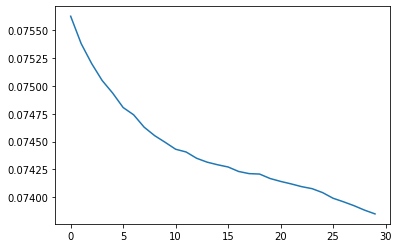

In [69]:
plt.plot(train_losses,label = "Train losses")


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


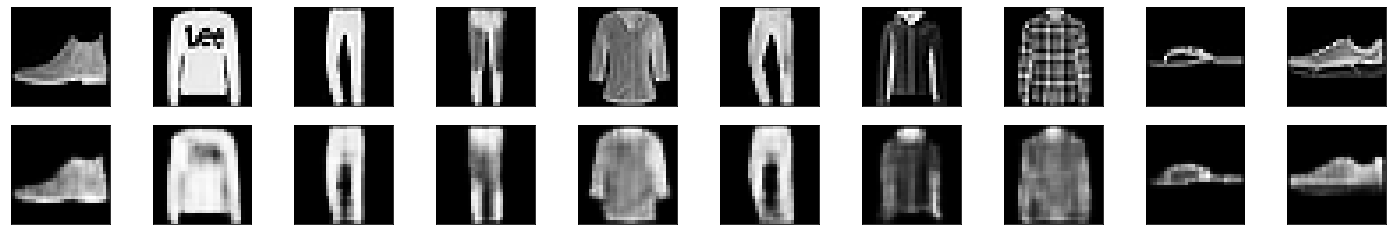

In [71]:

# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = autoencoder(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
output = output.view(batch_size, 1, 28, 28)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)


From the result, it is showed the decoding results display the original images and the reconstructed images. 

##Question 2##
2 layers cnn
##2.1 Using ConvNets##
uisng CNNs in this problem to classify the various clothing items in the fashion MNIST dataset. We get a final accuracy of 90.85% on the test set. The architecture of the CNN is as follows.

A 2D convolution layer of 32 kernels of size 5x5.
Max polling over a 2x2 area to downsample the output.
Another 2D convolution layer of 32 kernels of size 5*5.
rical crossentropy since this is a multi class classification problem.
The choices for the size of the convolution layers and dense layer are standard baseline numbers for image classification problems.

In [0]:

import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self,num_classes=10):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.AvgPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.AvgPool2d(2))
        self.fc1 = nn.Linear(7*7*32, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [0]:
num_epochs = 50
num_classes = 10
batch_size = 100
learning_rate = 0.001

In [0]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = CNN(num_classes).to(device)

In [0]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [0]:
# function to do evaluation (calculate the accuracy) in gpu
def evaluation(dataloader):
     total, correct = 0, 0
     #keeping the network in evaluation mode 
     model.eval()
     for data in dataloader:
         inputs, labels = data
         #moving the inputs and labels to gpu
         inputs, labels = inputs.to(device), labels.to(device)
         outputs = model(inputs)
         _, pred = torch.max(outputs.data, 1)
         total += labels.size(0)
         correct += (pred == labels).sum().item()
     return 100 * correct / total

In [0]:
epoch=50

In [118]:
test_losses=[]
train_losses=[]
for e in range(epoch):
    train_loss = 0
    test_loss = 0
    accuracy = 0
    for images, labels in train_loader:
        images,labels = images.to(device),labels.to(device)
        optimizer.zero_grad()
        op = model(images)
        loss = criterion(op, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    else:
        with torch.no_grad():
            model.eval()
            for images,labels in test_loader:
                images,labels = images.to(device),labels.to(device)
                log_ps = model(images)
                prob = torch.exp(log_ps)
                top_probs, top_classes = prob.topk(1, dim=1)
                equals = labels == top_classes.view(labels.shape)
                accuracy += equals.type(torch.FloatTensor).mean()
                test_loss += criterion(log_ps, labels)
        model.train()
    print("Epoch: {}/{}.. ".format(e+1, epoch),
              "Training Loss: {:.3f}.. ".format(train_loss/len(train_loader)),
              "Test Loss: {:.3f}.. ".format(test_loss/len(test_loader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))
    train_losses.append(train_loss/len(train_loader))
    test_losses.append(test_loss/len(test_loader))
        

Epoch: 1/50..  Training Loss: 0.459..  Test Loss: 0.328..  Test Accuracy: 0.882
Epoch: 2/50..  Training Loss: 0.295..  Test Loss: 0.351..  Test Accuracy: 0.874
Epoch: 3/50..  Training Loss: 0.258..  Test Loss: 0.290..  Test Accuracy: 0.894
Epoch: 4/50..  Training Loss: 0.234..  Test Loss: 0.280..  Test Accuracy: 0.900
Epoch: 5/50..  Training Loss: 0.215..  Test Loss: 0.253..  Test Accuracy: 0.908
Epoch: 6/50..  Training Loss: 0.195..  Test Loss: 0.245..  Test Accuracy: 0.911
Epoch: 7/50..  Training Loss: 0.186..  Test Loss: 0.249..  Test Accuracy: 0.911
Epoch: 8/50..  Training Loss: 0.174..  Test Loss: 0.249..  Test Accuracy: 0.913
Epoch: 9/50..  Training Loss: 0.163..  Test Loss: 0.231..  Test Accuracy: 0.921
Epoch: 10/50..  Training Loss: 0.151..  Test Loss: 0.259..  Test Accuracy: 0.906
Epoch: 11/50..  Training Loss: 0.143..  Test Loss: 0.242..  Test Accuracy: 0.915
Epoch: 12/50..  Training Loss: 0.132..  Test Loss: 0.263..  Test Accuracy: 0.912
Epoch: 13/50..  Training Loss: 0.124.

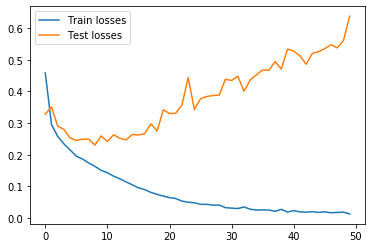

In [119]:

plt.plot(train_losses,label = "Train losses")
plt.plot(test_losses, label = "Test losses")
plt.legend()

##2.2#
Using Resnet for fashion mnist

In [218]:
batchSize=4

##load data
transform = transforms.Compose([transforms.Resize(224),transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,)),])

trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batchSize, shuffle=True, num_workers=0)

testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batchSize, shuffle=False, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

####network
def vgg_block(num_convs, in_channels, num_channels):
    layers=[]
    for i in range(num_convs):
        layers+=[nn.Conv2d(in_channels=in_channels, out_channels=num_channels, kernel_size=3, padding=1)]
        in_channels=num_channels
    layers +=[nn.ReLU()]
    layers +=[nn.MaxPool2d(kernel_size=2, stride=2)]
    return nn.Sequential(*layers)

class VGG(nn.Module):
    def __init__(self):
        super(VGG,self).__init__()
        self.conv_arch=((1,1,64),(1,64,128),(2,128,256),(2,256,512),(2,512,512))
        layers=[]
        for (num_convs,in_channels,num_channels) in self.conv_arch:
            layers+=[vgg_block(num_convs,in_channels,num_channels)]
        self.features=nn.Sequential(*layers)
        self.dense1 = nn.Linear(512*7*7,4096)
        self.drop1 = nn.Dropout(0.5)
        self.dense2 = nn.Linear(4096, 4096)
        self.drop2 = nn.Dropout(0.5)
        self.dense3 = nn.Linear(4096, 10)

    def forward(self,x):
        x=self.features(x)
        x=x.view(-1,512*7*7)
        x=self.dense3(self.drop2(F.relu(self.dense2(self.drop1(F.relu(self.dense1(x)))))))
        return x

net=VGG().cuda()
print (net)
criterion=nn.CrossEntropyLoss()
optimizer=optim.SGD(net.parameters(),lr=0.05,momentum=0.9)


VGG(
  (features): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [226]:

#train
running_losses=[]
for epoch in range(10):
    
    start = time.time()
    running_loss=0
    for i,data in enumerate(trainloader,0):
        # print (inputs,labels)
        image,label=data


        image=image.cuda()
        label=label.cuda()
        image=Variable(image)
        label=Variable(label)

        # imshow(torchvision.utils.make_grid(image))
        # plt.show()
        # print (label)
        optimizer.zero_grad()

        print (image.shape)
        outputs=net(image)
        # print (outputs)
        loss=criterion(outputs,label)

        loss.backward()
        optimizer.step()
        running_loss+=loss.data
    running_losses.append(running_loss/len(trainloader))
    print("Epoch: {}/{}.. ".format(epoch),
              "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)))

torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4, 1, 224, 224])
torch.Size([4,

IndexError: ignored

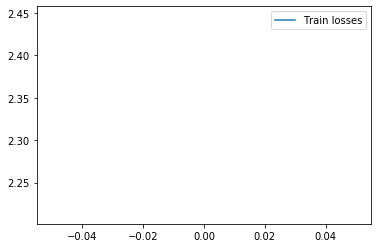

In [227]:
plt.plot(running_losses,label = "Train losses")
plt.legend()

In [228]:

net.eval()
correct=0
total=0
for data in testloader:
    images,labels=data
    images=images.cuda()
    labels=labels.cuda()
    outputs=net(Variable(images))
    _,predicted=torch.max(outputs,1)
    total+=labels.size(0)
    correct+=(predicted==labels).sum()
print('Accuracy of the network on the %d test images: %d %%' % (total , 100 * correct / total))

Accuracy of the network on the 10000 test images: 10 %


The transfer learning model improved over 10 epochs from a validation loss and accuracy of about 1.739 and 0.366 to about 1.596 and 0.413, respectively. The training losses and accuracies are similarly poor. Overall, this model performed much worse than the deep CNN in the previous part.

##Question3##
##USING KERAS FOR Q3#
#cnn and rnn


In [144]:
import pandas as pd
import nltk
import collections
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import preprocess_input
from keras.layers.embeddings import Embedding
from keras.layers import Input, Dense, Dropout, Activation, Flatten, GlobalMaxPooling1D, LSTM
from keras.callbacks import TensorBoard
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from sklearn.utils import class_weight
from keras.layers import LSTM, Conv1D, GlobalMaxPooling1D
import regex
from nltk.corpus import stopwords
import gensim
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing import sequence
import  pandas as pd

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [152]:
import re
url = 'https://raw.githubusercontent.com/verajiaqitang/Analy590_assignment3/master/tweets_with_labels.csv'
tweets = pd.read_csv(url, sep = '\t' ,error_bad_lines=False)

tweets.head()


,id,tweet,k1,k2,k3,k4,k5,k6,k7,k8,k9,k10,k11,k12,k13,k14,k15
0,1,Jazz for a Rainy Afternoon: {link},0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
1,2,RT: @mention: I love rainy days.,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,1.0,0.0,0.0,0.000,0.0,0.0
2,3,Good Morning Chicago! Time to kick the Windy C...,0.0,0.0,0.0,0.0,0.0,0.0,1.000,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0
3,6,Preach lol! :) RT @mention: #alliwantis this t...,0.0,0.0,0.0,0.0,0.0,0.0,0.604,0.0,0.196,0.0,0.0,0.0,0.201,0.0,0.0
4,9,@mention good morning sunshine,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,0.0,1.000,0.0,0.0


In [0]:


# clean tweets
stopWords = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocess_tweets(tweet):
    tweet = re.sub("@mention", "",tweet)
    tweet = re.sub("{link}", "",tweet)
    tweet = re.sub("[^A-Za-z]"," ",tweet)
    tweet = re.sub(r'\bRT\b', '', tweet)
    tweet = re.sub("\s+"," ",tweet)
    tokens = word_tokenize(tweet)
    words = [word for word in tokens if word not in stopWords]
    words = [stemmer.stem(w).strip("'") for w in words]
    words = [lemmatizer.lemmatize(w, pos="a") for w in words]
    words = [word for word in words if len(word)!=1]
    final_tweet = ' '.join(words)
    return final_tweet

new_tweet = [preprocess_tweets(x) for x in list(tweets.tweet)]
tweets['new_tweets'] = new_tweet

In [157]:
token = [word_tokenize(x) for x in list(tweets.new_tweets)]

# clean out empty new_tweets by removing them
remove_lst=[]
for w in token:
    remove_lst.append(len(w))
bad_idx = [n for n,x in enumerate(remove_lst) if x == 0]
tweets_updated = tweets.drop(bad_idx)

# preprocess finished and define X and y for train test split

X = [word_tokenize(x) for x in list(tweets_updated['new_tweets'])]

# label y for any k1 to k15 not equal to 0
label = tweets_updated.loc[:,'k1':'k15']
label[tweets_updated != 0] = 1
y = label.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)
print('X_train shape: ', len(X_train))
print('X_test shape: ', len(X_test))
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  54551
X_test shape:  23379
y_train shape:  (54551, 15)
y_test shape:  (23379, 15)


In [0]:
# padding token sequense to max length of 40
X_train_padded = sequence.pad_sequences(X_train, maxlen=40, padding="post", truncating="post", value='_pad_',dtype=object)
X_test_padded = sequence.pad_sequences(X_test, maxlen=40, padding="post", truncating="post", value='_pad_',dtype=object)

train_corpus = list(tweets_updated.new_tweets)
train_cor_tk = [word_tokenize(x) for x in train_corpus]
corpus_padded = sequence.pad_sequences(train_cor_tk, maxlen=40,padding="post", truncating="post", value='_pad_',dtype=object)

corpus_padded = corpus_padded.tolist()
X_train_padded = X_train_padded.tolist()
X_test_padded = X_test_padded.tolist()

In [159]:
#  train word2vec and vectorizing training set and test set 
w2v_model = Word2Vec(corpus_padded, min_count=1, size = 20, workers=1, window=3)

# vector with size train/test, maxlen = 40 
X_train_vec = np.empty([len(X_train), 40, 20])
X_test_vec = np.empty([len(X_test), 40, 20])

idx_train = 0
for w in X_train_padded:
    X_train_vec[idx_train, :, :] = w2v_model[w]
    idx_train += 1

idx_test = 0
for w in X_test_padded:
    X_test_vec[idx_test,:,:] = w2v_model[w]
    idx_test += 1

print('X_train_vec shape: ', X_train_vec.shape)
print('X_test_vec shape: ', X_test_vec.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


X_train_vec shape:  (54551, 40, 20)
X_test_vec shape:  (23379, 40, 20)


# ##simple rnn##

using a simple RNN to classify for tweets . As shown in  classfication accuracy of 94.4% for test.

In [175]:
#  Build LSTM model
model_rnn = Sequential()
model_rnn.add(LSTM(128, input_shape = (40, 20)))
model_rnn.add(Dense(128, activation = 'relu'))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(64, activation = 'relu'))
model_rnn.add(Dropout(0.2))
model_rnn.add(Dense(15, activation ='sigmoid'))

model_rnn.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

history = model_rnn.fit(X_train_vec, y_train,
                        epochs=10, batch_size=500,
                        validation_data=(X_test_vec, y_test))

Train on 54551 samples, validate on 23379 samples
Epoch 1/10
54551/54551 [==============================] - 12s 224us/step - loss: 0.3659 - acc: 0.8567 - val_loss: 0.3214 - val_acc: 0.8748
Epoch 2/10
54551/54551 [==============================] - 11s 196us/step - loss: 0.3297 - acc: 0.8730 - val_loss: 0.3202 - val_acc: 0.8748
Epoch 3/10
54551/54551 [==============================] - 11s 198us/step - loss: 0.3141 - acc: 0.8753 - val_loss: 0.3036 - val_acc: 0.8799
Epoch 4/10
54551/54551 [==============================] - 11s 197us/step - loss: 0.2703 - acc: 0.8953 - val_loss: 0.2185 - val_acc: 0.9180
Epoch 5/10
54551/54551 [==============================] - 11s 198us/step - loss: 0.2099 - acc: 0.9226 - val_loss: 0.1868 - val_acc: 0.9297
Epoch 6/10
54551/54551 [==============================] - 11s 197us/step - loss: 0.1882 - acc: 0.9325 - val_loss: 0.1709 - val_acc: 0.9371
Epoch 7/10
54551/54551 [==============================] - 11s 197us/step - loss: 0.1772 - acc: 0.9372 - val_loss: 0.

In [0]:
from keras.datasets import fashion_mnist
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D 
from keras.layers import UpSampling2D, Dropout, Activation, Flatten 
from keras.layers import LeakyReLU, LSTM, Conv1D, GlobalMaxPooling1D
from keras.models import Model, Sequential
from matplotlib import pyplot as plt
from keras.utils import np_utils
import keras
from keras.applications import VGG16
from keras.preprocessing.image import img_to_array, array_to_img
from sklearn.model_selection import train_test_split
from keras.applications.vgg16 import preprocess_input
import pandas as pd
from keras.layers.embeddings import Embedding
from keras.callbacks import TensorBoard
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from sklearn.utils import class_weight
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [0]:
#  evaluate the model
score = model_rnn.evaluate(X_test_vec, y_test, batch_size=64, verbose = 0)

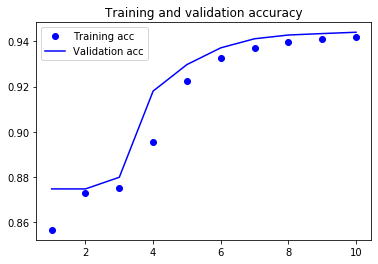

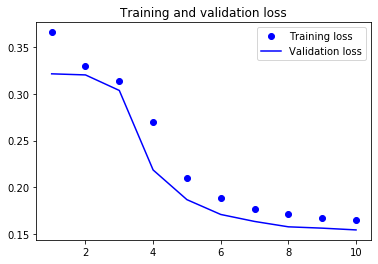

In [178]:
plot_model_training_results(history)


In [179]:
from sklearn import metrics
import matplotlib.pyplot as plt

print('Train loss: ', history.history['loss'][9]) 
print('Train accuracy: ', history.history['acc'][9])

print('Test loss: ', score[0])
print('Test accuracy: ', score[1])

Train loss:  0.164790458886943
Train accuracy:  0.9420114609052739
Test loss:  0.1543897272177384
Test accuracy:  0.9439839351967049


##1 D CNN
 using a 1D CNN layer with 64 kernels .  achieved the  94.7% accuracy for test data

In [163]:
model_cnn = Sequential()
model_cnn.add(Conv1D(128, 3, activation='relu', padding = 'valid', strides=1, input_shape=(40,20)))
model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dense(64))
model_cnn.add(Dropout(0.2))
model_cnn.add(Activation('relu'))
model_cnn.add(Dense(15, activation ='sigmoid'))

model_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_cnn = model_cnn.fit(X_train_vec, y_train, epochs=10, batch_size=128,
                        validation_data=(X_test_vec, y_test))

Train on 54551 samples, validate on 23379 samples
Epoch 1/10
54551/54551 [==============================] - 4s 70us/step - loss: 0.2356 - acc: 0.9121 - val_loss: 0.1693 - val_acc: 0.9393
Epoch 2/10
54551/54551 [==============================] - 3s 55us/step - loss: 0.1771 - acc: 0.9382 - val_loss: 0.1597 - val_acc: 0.9428
Epoch 3/10
54551/54551 [==============================] - 3s 56us/step - loss: 0.1688 - acc: 0.9409 - val_loss: 0.1559 - val_acc: 0.9443
Epoch 4/10
54551/54551 [==============================] - 3s 56us/step - loss: 0.1644 - acc: 0.9423 - val_loss: 0.1537 - val_acc: 0.9446
Epoch 5/10
54551/54551 [==============================] - 3s 57us/step - loss: 0.1613 - acc: 0.9432 - val_loss: 0.1522 - val_acc: 0.9451
Epoch 6/10
54551/54551 [==============================] - 3s 58us/step - loss: 0.1590 - acc: 0.9439 - val_loss: 0.1500 - val_acc: 0.9460
Epoch 7/10
54551/54551 [==============================] - 3s 57us/step - loss: 0.1570 - acc: 0.9445 - val_loss: 0.1497 - val_acc

In [0]:
# evaluate the model
score_cnn = model_cnn.evaluate(X_test_vec, y_test, batch_size=64, verbose = 0)

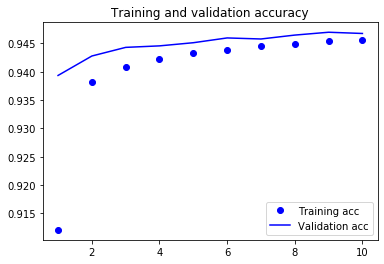

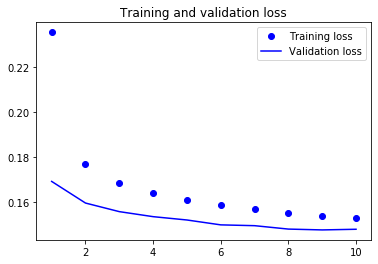

In [181]:
plot_model_training_results(history_cnn)

In [182]:
from sklearn import metrics
import matplotlib.pyplot as plt

print('Train loss: ', history_cnn.history['loss'][9]) 
print('Train accuracy: ', history_cnn.history['acc'][9])

print('Test loss: ', score_cnn[0])
print('Test accuracy: ', score_cnn[1])

Train loss:  0.15290409838919902
Train accuracy:  0.9456313230454177
Test loss:  0.1480935423995182
Test accuracy:  0.9467528017625066


###3.3 Comparison betwen SimpleRNN and CNN for text classificiation###

Text(0.5, 1.0, 'Text Classification Accuracy RNN CNN Comparison')

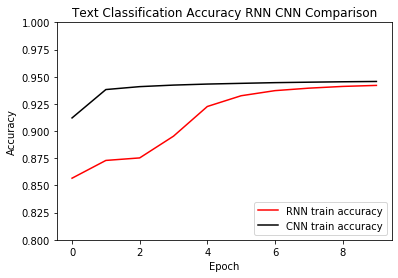

In [184]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'], label='RNN train accuracy', color = 'r')
plt.plot(history_cnn.history['acc'], label = 'CNN train accuracy', color = 'k')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.8, 1])
plt.legend(loc='lower right')
plt.title('Text Classification Accuracy RNN CNN Comparison')

Text(0.5, 1.0, 'Text Classification Loss RNN CNN Comparison')

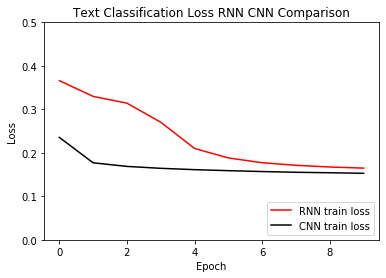

In [185]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='RNN train loss', color = 'r')
plt.plot(history_cnn.history['loss'], label = 'CNN train loss', color = 'k')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 0.5])
plt.legend(loc='lower right')
plt.title('Text Classification Loss RNN CNN Comparison')


for rnn and cnn in this case, the overall accuracy  of both of them(94.4% and 94.7%)  are very similar. However,the training time for CNN is much shorter than Rnn. 